In [1]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 

from helpers.composite_helpers import *



In [2]:
def analyze_transform_for_scatter(idd, train_samp_1, train_samp_2, test_samp_1, test_samp_2, n_features, n_epochs, batch_size, lr, patience, device, early_stop = True, visualize = True, seed = None):
    
    if seed is not None:
        #print(f"Using seed {seed}...")
        torch.manual_seed(seed)
        np.random.seed(seed)
            
    dense_net = NeuralNet(input_shape = n_features)
    criterion = F.binary_cross_entropy #nn.BCELoss()
    optimizer = torch.optim.Adam(dense_net.parameters(), lr=lr)

    dense_net.to(device)
    
    if early_stop:
        early_stopping = EarlyStopping(patience=patience)
    
    # transformed SIM has label 0, DAT has label 1
    # make the input and output data
    nn_train_data = np.concatenate((train_samp_1, train_samp_2))
    nn_train_labs = np.concatenate((torch.zeros((train_samp_1.shape[0], 1)), torch.ones((train_samp_2.shape[0],1)))) 
    
    # get weights in case we're oversampling
    class_weights = class_weight.compute_class_weight('balanced', np.unique(nn_train_labs.reshape(-1)), nn_train_labs.reshape(-1))
    class_weights = dict(enumerate(class_weights))        
    
    # train-test split
    val_size = 0.2
    
    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(nn_train_data, nn_train_labs, test_size=val_size)

    X_test = np.concatenate((test_samp_1, test_samp_2))
    y_test = np.concatenate((torch.zeros((test_samp_1.shape[0], 1)), torch.ones((test_samp_2.shape[0],1))))
        
    print("Train data, labels shape:", X_train.shape, y_train.shape)
    print("Val data, labels shape:", X_val.shape, y_val.shape)
    print("Test data, labels  shape:", X_test.shape, y_test.shape)
    
    for i in range(X_train.shape[1]):
        print(f"Feature {i} min, max for train: ({np.min(X_train[:,i])},{np.max(X_train[:,i])}), val: ({np.min(X_val[:,i])},{np.max(X_val[:,i])}), test: ({np.min(X_test[:,i])},{np.max(X_test[:,i])})")  
        

    # send to device
    X_train = np_to_torch(X_train, device)
    X_val = np_to_torch(X_val, device)
    X_test = np_to_torch(X_test, device)
    y_train = np_to_torch(y_train, device)
    y_val = np_to_torch(y_val, device)
     

    epochs, epochs_val = [], []
    losses, losses_val = [], []

    for epoch in tqdm(range(n_epochs)):
        # batching
        indices_list = torch.split( torch.randperm( X_train.shape[0] ), batch_size )
        # initialise lists to store batch stats
        losses_batch_per_e = []
        
        for i, indices in enumerate( indices_list ): # going through the batches
            # calculate the loss, backpropagate
            optimizer.zero_grad()
            
            batch_data = X_train[indices]
            batch_labels = y_train[indices]
            
            # get the weights
            batch_weights = (torch.ones(batch_labels.shape, device=device)
                        - batch_labels)*class_weights[0] \
                        + batch_labels*class_weights[1]

            
            loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses_batch_per_e.append(loss.detach().cpu().numpy())

        epochs.append(epoch)
        losses.append(np.mean(losses_batch_per_e))
        
        # validation
       

        with torch.no_grad():
            # batching
            val_indices_list = torch.split( torch.randperm( X_val.shape[0] ), batch_size )
            # initialise lists to store batch stats
            val_losses_batch_per_e = []

            for i, indices in enumerate( val_indices_list ): # going through the batches
                # calculate the loss, backpropagate
                optimizer.zero_grad()

                batch_data = X_val[indices]
                batch_labels = y_val[indices]

                # get the weights
                batch_weights = (torch.ones(batch_labels.shape, device=device)
                            - batch_labels)*class_weights[0] \
                            + batch_labels*class_weights[1]


                val_loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights) 

                val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

        epochs_val.append(epoch)
        losses_val.append(np.mean(val_losses_batch_per_e))

        if early_stop:
            early_stopping(np.mean(val_losses_batch_per_e))
                
        if early_stopping.early_stop:
            break


    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        outputs = dense_net(X_test).detach().cpu().numpy()
 
    return outputs

In [3]:
# load in the reverse rescales
path_to_minmax = "/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/col_minmax.npy"
col_minmax = np.load(path_to_minmax)

"""
"""
"""
COMPUTING PARAMETERS
"""
"""
"""

os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)



Using device: cuda


In [4]:
"""
"""
"""
RUN PARAMETERS
"""
"""
"""

seed = 1
n_features = 5
num_signal_to_inject = 2500
oversampnum = 6


epochs_NN =  100
batch_size_NN = 128
lr_NN = 0.001
patience_NN = 20


context_endpoints = (2500, 4500)


bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
              "ob2": [4100, 4500]}

binning_scheme = np.linspace(-3.5, 3.5, 50)


"""
"""
"""
STS DATA
"""
"""
"""

STS_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/"

STS_bkg = ToyDataset(STS_dir, "STS_bkg.npy")
STS_sig = ToyDataset(STS_dir, "STS_sig.npy")

STS_bkg_dataset = STS_bkg.pull_from_mass_range([bands_dict["sr"]])
STS_sig_dataset = STS_sig.pull_from_mass_range([bands_dict["sr"]])

STS_bkg_dataset = minmaxscale(STS_bkg_dataset.data, col_minmax, lower = 0, upper = 1, forward = True)
STS_sig_dataset = minmaxscale(STS_sig_dataset.data, col_minmax, lower = 0, upper = 1, forward = True)




In [5]:
"""
"""
"""
EVAL SIM2REAL
"""
"""
"""

# sim2real

sim2real_exp_dir = f"/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_{num_signal_to_inject}sig_f/"

num_layers_BD_sim = 1
num_hidden_features_BD_sim = 128
num_blocks = 15

num_layers_s2d = 2
num_nodes_s2d = 16


loc_id_BD_sim = f"BD_sim_Masked_PRQ_AR_{num_layers_BD_sim}layers_{num_hidden_features_BD_sim}hidden_{num_blocks}blocks_{seed}seed"
loc_id_s2d = f"PRQ_Coupling_{num_layers_s2d}layers_{num_nodes_s2d}nodes_{seed}seed"
BD_sim_training_dir = os.path.join(sim2real_exp_dir, f"saved_models_{loc_id_BD_sim}/")
s2d_training_dir = os.path.join(BD_sim_training_dir, f"saved_models_{loc_id_s2d}/")
s2d_samples_dir = os.path.join(s2d_training_dir, f"npy_samples/")

oversamples_dir = os.path.join(s2d_training_dir, f"oversampling_{oversampnum}/")


# load in the dat samples
dat_samples_train = np.load(os.path.join(s2d_samples_dir, f"sr_DAT.npy")) 
dat_samples_train = minmaxscale(dat_samples_train, col_minmax, lower = -3, upper = 3, forward = False)
dat_samples_train = minmaxscale(dat_samples_train, col_minmax, lower = 0, upper = 1, forward = True)

# cathode
cathode_exp_dir = f"/global/home/users/rrmastandrea/CATHODE/CATHODE_models/nsig_inj{num_signal_to_inject}/seed{seed}/"



In [6]:
seed_NN = 4


print("Evaluating sim2real oversampled...")

oversampled_sim_samples_train = np.load(os.path.join(oversamples_dir, f"transBD.npy"))
oversampled_sim_samples_train = minmaxscale(oversampled_sim_samples_train, col_minmax, lower = -3, upper = 3, forward = False)
oversampled_sim_samples_train = minmaxscale(oversampled_sim_samples_train, col_minmax, lower = 0, upper = 1, forward = True)

#feta_results = analyze_transform_for_scatter(f"sim2real_oversamp{oversampnum}_{seed_NN}", oversampled_sim_samples_train[:,:-1], dat_samples_train[:,:-1], STS_bkg_dataset[:,:-1], STS_sig_dataset[:,:-1], n_features, epochs_NN, batch_size_NN, lr_NN, patience_NN, device, visualize = True, seed = seed_NN)
#np.save("feta_results", feta_results)




print("Evaluating cathode...")

cathode_trans_samps = np.load(os.path.join(cathode_exp_dir, f"SR_samples.npy"))
#cathode_results = analyze_transform_for_scatter(f"cathode_{seed_NN}", cathode_trans_samps[:,:-1], dat_samples_train[:,:-1], STS_bkg_dataset[:,:-1], STS_sig_dataset[:,:-1], n_features, epochs_NN, batch_size_NN, lr_NN, patience_NN, device, visualize = True, seed = seed_NN)
#np.save("cathode_results", cathode_results)




"""
"
"
SUPERVISED CLASSIFIER
"
"""

true_samples_dir = f"/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/"


print("Evaluating fully supervised case...")

true_samples_dir = f"/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/"

true_sup_bkg = np.load(os.path.join(true_samples_dir, f"true_sup_bkg.npy"))
true_sup_sig = np.load(os.path.join(true_samples_dir, f"true_sup_sig.npy"))
true_sup_bkg = minmaxscale(true_sup_bkg, col_minmax, lower = 0, upper = 1, forward = True)
true_sup_sig = minmaxscale(true_sup_sig, col_minmax, lower = 0, upper = 1, forward = True)

full_sup_results = analyze_transform_for_scatter(f"full_sup_{seed_NN}",true_sup_bkg[:,:-1], true_sup_sig[:,:-1], STS_bkg_dataset[:,:-1], STS_sig_dataset[:,:-1], n_features, epochs_NN, batch_size_NN, lr_NN, patience_NN, device, visualize = True, seed = seed_NN)
np.save("full_sup_results", full_sup_results)


          
print("Done!")



Evaluating sim2real oversampled...
Evaluating cathode...
Evaluating fully supervised case...


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 1. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train data, labels shape: (88478, 5) (88478, 1)
Val data, labels shape: (22120, 5) (22120, 1)
Test data, labels  shape: (40000, 5) (40000, 1)
Feature 0 min, max for train: (0.001400891706072553,0.8822443227544402), val: (0.00642888751918428,0.786494071175403), test: (0.005337465088814497,0.8737365007400513)
Feature 1 min, max for train: (1.34893060258784e-06,0.9002487904503079), val: (9.201058859656436e-06,0.7292333904404231), test: (5.234752279648092e-06,0.7705807685852051)
Feature 2 min, max for train: (-0.008684253349770021,0.993570524323316), val: (-0.0022213039573610828,0.971174698827125), test: (0.018567243590950966,0.977394163608551)
Feature 3 min, max for train: (-0.004064089747005081,0.9858325427719794), val: (-0.004112923560124038,0.9817704396256215), test: (0.0008824266260489821,0.9812214374542236)
Feature 4 min, max for train: (0.018577969942033114,0.862042529677702), val: (0.06435662730232243,0.8261909236948899), test: (0.06629329919815063,0.8438825011253357)


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]

Done!


In [7]:

feta_results = np.load("feta_results.npy")
cathode_results = np.load("cathode_results.npy")
full_sup_results = np.load("full_sup_results.npy")



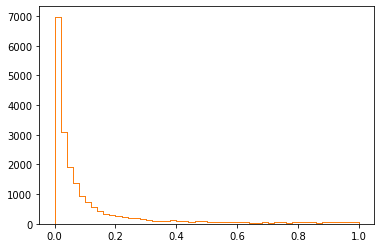

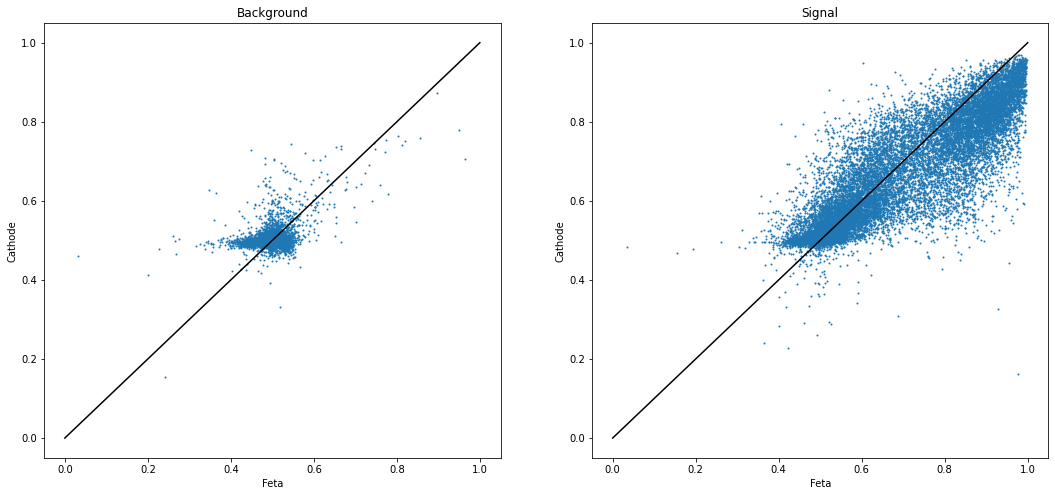

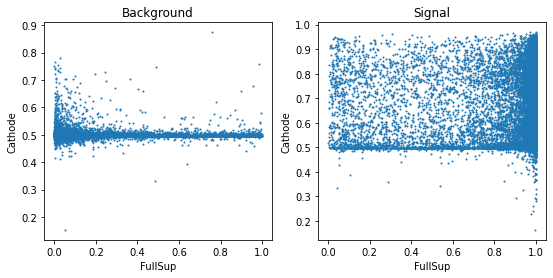

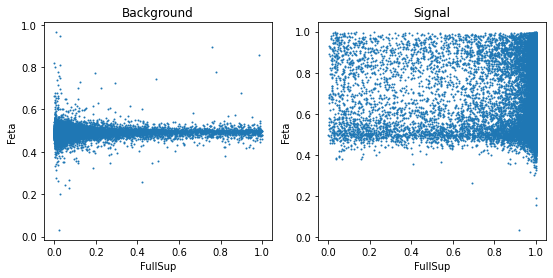

In [20]:

plt.figure()
plt.hist(full_sup_results[:20000], bins = 50, histtype = "step")
plt.hist(full_sup_results[:20000], bins = 50, histtype = "step")
plt.show()




fig, ax = plt.subplots(1, 2, figsize = (18, 8))
ax[0].scatter(feta_results[:20000], cathode_results[:20000], s = 1)
ax[0].plot([0, 1], [0, 1], color = "black")
ax[0].title.set_text("Background")
ax[0].set_xlabel("Feta")
ax[0].set_ylabel("Cathode")

ax[1].scatter(feta_results[20000:], cathode_results[20000:], s = 1)
ax[1].plot([0, 1], [0, 1], color = "black")
ax[1].title.set_text("Signal")
ax[1].set_xlabel("Feta")
ax[1].set_ylabel("Cathode")
plt.show()


fig, ax = plt.subplots(1, 2, figsize = (18, 8))
ax[0].scatter(full_sup_results[:20000], cathode_results[:20000], s = 1)
ax[0].title.set_text("Background")
ax[0].set_xlabel("FullSup")
ax[0].set_ylabel("Cathode")

ax[1].scatter(full_sup_results[20000:], cathode_results[20000:], s = 1)
ax[1].title.set_text("Signal")
ax[1].set_xlabel("FullSup")
ax[1].set_ylabel("Cathode")
plt.show()



fig, ax = plt.subplots(1, 2, figsize = (18, 8))
ax[0].scatter(full_sup_results[:20000], feta_results[:20000], s = 1)
ax[0].title.set_text("Background")
ax[0].set_xlabel("FullSup")
ax[0].set_ylabel("Feta")

ax[1].scatter(full_sup_results[20000:], feta_results[20000:], s = 1)
ax[1].title.set_text("Signal")
ax[1].set_xlabel("FullSup")
ax[1].set_ylabel("Feta")
plt.show()


